In [1]:
# sources
# https://stackoverflow.com/questions/11303225/how-to-remove-multiple-indexes-from-a-list-at-the-same-time



In [45]:
# imports

import pandas as pd
import numpy as np
import os
import random
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix



In [56]:
def tokenize_and_preserve_labels(tokenizer, sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        
        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

#     return sentence, text_labels


In [57]:
def process_data(tokenizer, sentences, labels, MAX_LEN, tag2idx, bs, random_seed=42):
    
    tokenized_texts_and_labels = [
        tokenize_and_preserve_labels(tokenizer, sent, labs)
        for sent, labs in zip(sentences, labels)
    ]

    # contains more than 305603 tokens (BERT split each token up more) grouped into 1173 sentences.
    tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
    labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

    # contains padded versions of the 1173 sentences.
    input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                              maxlen=MAX_LEN, dtype="long", value=0.0,
                              truncating="post", padding="post")

    tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                         maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                         dtype="long", truncating="post")
    
    attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

    # split data
    tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                                random_state=42, test_size=0.1)
    tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                                 random_state=42, test_size=0.1)
    
#     [print(tokenizer.decode(example)) for example in tr_inputs[0]]
    
    tr_inputs = torch.tensor(tr_inputs)
    val_inputs = torch.tensor(val_inputs)
    tr_tags = torch.tensor(tr_tags)
    val_tags = torch.tensor(val_tags)
    tr_masks = torch.tensor(tr_masks)
    val_masks = torch.tensor(val_masks)

    train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

    valid_data = TensorDataset(val_inputs, val_masks, val_tags)
    valid_sampler = SequentialSampler(valid_data)
    valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

    return train_dataloader, valid_dataloader


In [64]:
def train(train_dataloader, valid_dataloader, epochs=5, dropout=0.3):


    # initialize model
    model = BertForTokenClassification.from_pretrained(
        "emilyalsentzer/Bio_ClinicalBERT",  # bert-base-cased
        num_labels=len(tag2idx),
        output_attentions=False,
        output_hidden_states=False,
        attention_probs_dropout_prob=dropout,  # 0.3
        hidden_dropout_prob=dropout  # 0.3
    )

    model.cuda()

    FULL_FINETUNING = True
    if FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ['bias', 'gamma', 'beta']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.0}
        ]
    else:
        param_optimizer = list(model.classifier.named_parameters())
        optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

    optimizer = AdamW(
        optimizer_grouped_parameters,
        lr=3e-5,
        eps=1e-8
    )

    max_grad_norm = 1.0

    # Total number of training steps is number of batches * number of epochs.
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )   


    ## Store the average loss after each epoch so we can plot them.
    loss_values, validation_loss_values = [], []

    accuracy_values, F1_values, precision_values, recall_values = [], [], [], []

    done = False
    for e in trange(epochs, desc="Epoch"):
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.

        # Put the model into training mode.
        model.train()
        # Reset the total loss for this epoch.
        total_loss = 0

        # Training loop
        for step, batch in enumerate(train_dataloader):
            # add batch to gpu
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            # Always clear any previously calculated gradients before performing a backward pass.
            model.zero_grad()
            # forward pass
            # This will return the loss (rather than the model output)
            # because we have provided the `labels`.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
            # get the loss
            loss = outputs[0]
            # Perform a backward pass to calculate the gradients.
            loss.backward()
            # track train loss
            total_loss += loss.item()
            # Clip the norm of the gradient
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
            # update parameters
            optimizer.step()
            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)
        print("Average train loss: {}".format(avg_train_loss))

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)


        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        # Put the model into evaluation mode
        model.eval()
        # Reset the validation loss for this epoch.
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        predictions , true_labels = [], []
        for batch in valid_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            # Telling the model not to compute or store gradients,
            # saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have not provided labels.
                outputs = model(b_input_ids, token_type_ids=None,
                                attention_mask=b_input_mask, labels=b_labels)
            # Move logits and labels to CPU 
            logits = outputs[1].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences.
            eval_loss += outputs[0].mean().item()
            predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
            true_labels.extend(label_ids)
            
            # print out an input abstract, abstract's gold labels, and BERT's predictions
            if e == 4 and not done:
                [print(tokenizer.decode(example)) for example in b_input_ids[0]]
                [print(example) for example in b_labels[0]]
                [print(example) for example in predictions[0]]
                done = True

        eval_loss = eval_loss / len(valid_dataloader)
        validation_loss_values.append(eval_loss)
        print("Validation loss: {}".format(eval_loss))
        pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                     for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
        valid_tags = [tag_values[l_i] for l in true_labels
                                      for l_i in l if tag_values[l_i] != "PAD"]
        

        accuracy = accuracy_score(valid_tags, pred_tags)
        print("Validation Accuracy: {}".format(accuracy))
        accuracy_values.append(accuracy)

        precision = precision_score(valid_tags, pred_tags, labels=['0', '1'], average='macro')
        print("Validation Precision-Score: {}".format(precision))
        precision_values.append(precision)

        recall = recall_score(valid_tags, pred_tags, labels=['0', '1'], average='macro')
        print("Validation Recall-Score: {}".format(recall))
        recall_values.append(recall)

        F1 = f1_score(valid_tags, pred_tags, labels=['0', '1'], average='macro')
        print("Validation F1-Score: {}".format(F1))
        F1_values.append(F1)
        print()


    # plotting the metrics

    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12, 6)

    # Plot the learning curve.
    plt.plot(loss_values, 'b-o', label="training loss")
    plt.plot(validation_loss_values, 'r-o', label="validation loss")
    plt.plot(accuracy_values, 'g-o', label="accuracy")
    plt.plot(precision_values, 'c-o', label="precision")
    plt.plot(recall_values, 'm-o', label="recall")
    plt.plot(F1_values, 'y-o', label="F1")

    # Label the plot.
    plt.title("Learning curve")
    plt.xlabel("Epoch")
    plt.ylabel("Performance")
    plt.legend()

    plt.show()


    return accuracy, precision, recall, F1



Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint 

Average train loss: 0.34774838540364394
Validation loss: 0.22616371065378188
Validation Accuracy: 0.9069328870135075
Validation Precision-Score: 0.8010479584286302


Epoch:  20%|██        | 1/5 [00:20<01:20, 20.01s/it]

Validation Recall-Score: 0.7939550089677696
Validation F1-Score: 0.7974351281935169

Average train loss: 0.2182248727503148
Validation loss: 0.2000913441181183
Validation Accuracy: 0.9177058532330685
Validation Precision-Score: 0.8269372472666763


Epoch:  40%|████      | 2/5 [00:40<01:00, 20.13s/it]

Validation Recall-Score: 0.8107106002990994
Validation F1-Score: 0.8185075416794502

Average train loss: 0.19041204317049545
Validation loss: 0.19971216171979905
Validation Accuracy: 0.9175879870818698
Validation Precision-Score: 0.8226695575519183


Epoch:  60%|██████    | 3/5 [01:00<00:40, 20.20s/it]

Validation Recall-Score: 0.8229567372111448
Validation F1-Score: 0.822813048121438

Average train loss: 0.17435112138363448
C o
# # m p
# # a r i n g
t h e
e f f e c t i v e n e s s
o f
p e e r
m e n t o r
# # i n g
a n d
s t u d e n t
m e n t o r
# # i n g
i n
a
3 5
-
w e e k
f i t n e s s
p r o g r a m
f o r
o l d e r
a d u l t s
.
T o
i n v e s t i g a t e
t h e
a p p
# # l i c a
# # b i l i t y
a n d
e f f e c t i v e n e s s
o f
a
p e e r
-
m e n t o r
# # e d
e x e r c i s e
p r o g r a m
,
t h i s
s t u d y
c o m p a r e d
t h e
r e t e n t i o n
a n d
p a r t i c i p a t i o n
r a t e s
,
a n d
p h y s i c a l
i m p r o v e m e n t s
o f
o l d e r
a d u l t s
t r a i n e d
b y
p e e r
m e n t o r
# # s
(
P M
)
t o
a
g r o u p
t r a i n e d
b y
y o u n g
q u a l i f i e d
s t u d e n t
m e n t o r
# # s
(
S M
)
.
A
g r o u p
o f
o l d e r
a d u l t s
w e r e
p r e p a r e d
a s
p e e r
m e n t o r
# # s
t h r o u g h
a
3 0
-
w e e k
p r e p a r a t i o n
p r o g r a m
.
L a t e 

Epoch:  80%|████████  | 4/5 [01:21<00:20, 20.33s/it]

Validation Recall-Score: 0.8306144183222963
Validation F1-Score: 0.8246292786136592

Average train loss: 0.1648587424477393
Validation loss: 0.20226469337940217
Validation Accuracy: 0.9178472926145069
Validation Precision-Score: 0.821542047663256


Epoch: 100%|██████████| 5/5 [01:41<00:00, 20.29s/it]

Validation Recall-Score: 0.8295603270825017
Validation F1-Score: 0.8254739815951135



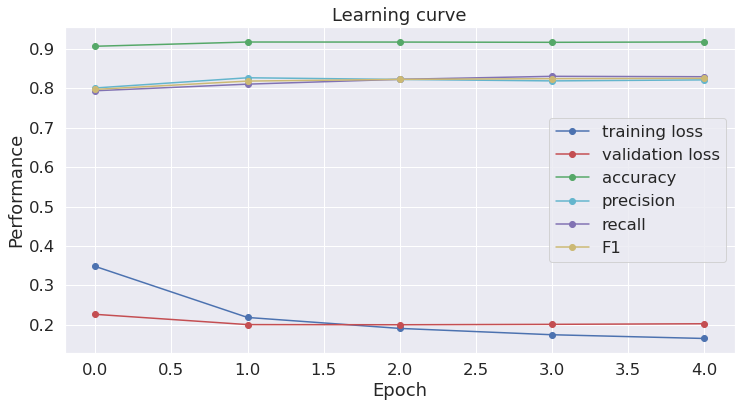

In [65]:
# main program

# reading in dataset which contains all tokens, and info for every token.
df_orig = pd.read_pickle('df_orig.pickle')

# groups tokens into their corresponding abstracts. groups labels into their corresponding abstracts.
def abstract_labels(df_orig):
    abstracts = []
    labels = []
    df_abs_groups = df_orig.groupby('PMID')
    for name, group in df_abs_groups: # no order
        group_labs = group.gold.tolist()
        s = group.head(1).abstract.tolist()[0]
        
        # remove None type values from label and abstracts. Snorkel does the same.
        remove_indices = [i for i, v in enumerate(group_labs) if v == None]
        group_labs = [i for j, i in enumerate(group_labs) if j not in remove_indices]
        s = [i for j, i in enumerate(s) if j not in remove_indices]
        
        abstracts.append(s)
        labels.append(group_labs)
    
    return abstracts, labels

# two corresponding lists of abstracts and labels for each abtract
abstracts, labels = abstract_labels(df_orig)


# define parameters
MAX_LEN = 512
bs = 12

# define labels
tag_values = ['0', '1', 'PAD']
tag2idx = {'0': 0, '1': 1, 'PAD': 2}
    

# device set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

# prepare data
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT',
                                          do_lower_case=False)  # bert-base-cased

train_dataloader, valid_dataloader = process_data(tokenizer, abstracts, labels, MAX_LEN, tag2idx, bs,
                                                  random_seed=42)

# train
accuracy, precision, recall, F1 = train(train_dataloader, valid_dataloader, epochs=5)

    